In [ ]:
# Install required libraries
!pip install transformers datasets accelerate scikit-learn

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

import pandas as pd
from datasets import Dataset
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# MOUNT DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# LOAD DATA
df = pd.read_excel('/content/drive/MyDrive/combined_urdu_dataset.xlsx')
dataset = Dataset.from_pandas(df)

In [ ]:
# FOR ENGLISH DATA TESTING
df = pd.read_csv('/content/drive/MyDrive/cleaned_news_dataset.csv')
dataset = Dataset.from_pandas(df)

In [ ]:
# TRAIN/TEST SPLIT
train_test = dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)
train_data = train_test["train"]
test_data = train_test["test"]

In [ ]:
# DEBUG STATEMENT
# CHECK IF VALUES FOLLOW FORMAT
print(train_data["label"][:10])
print(test_data["label"][:10])

[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


In [ ]:
# MODEL AND TOKENIZER
model_name = "bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2  # binary classification
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
# TOKENIZATION FUNCTION
def encode_batch(batch):
    return tokenizer(
        batch["text"],
        padding=True,
        truncation=True,
        max_length=256
    )

In [ ]:
# DEBUG STEP: check column names
df.columns

Index(['text', 'label'], dtype='object')

In [ ]:
train_data = train_data.map(encode_batch, batched=True)
test_data = test_data.map(encode_batch, batched=True)

train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/62727 [00:00<?, ? examples/s]

Map:   0%|          | 0/15682 [00:00<?, ? examples/s]

In [ ]:
# DATA LOADERS
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [ ]:
# OPTIMIZER, LOSS, SCHEDULER
lr = 1e-5
optimizer = AdamW(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

epochs = 2

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=total_steps
)

In [ ]:
# CHECK IF SAVED MODEL EXISTS
import os
save_dir = "/content/drive/MyDrive/my_saved_model"
os.listdir(save_dir)


['config.json',
 'model.safetensors',
 'vocab.txt',
 'tokenizer_config.json',
 'special_tokens_map.json',
 'tokenizer.json',
 'training_state.pt']

In [ ]:
# TRANSFORMER VERSION CHECK
# MUST BE >= 4.3.5
import transformers
print(transformers.__version__)


4.57.3


In [ ]:
# LOAD PRETRAINED MODEL
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

save_dir = "/content/drive/MyDrive/my_saved_model"

# Load tokenizer from original pretrained model
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

# Load your trained model
model = AutoModelForSequenceClassification.from_pretrained(save_dir)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
# TRAINING
save_dir = "/content/drive/MyDrive/my_saved_model"

for epoch in range(epochs):
    model.train()
    total_loss = 0
    batch_num = 0

    for batch in train_loader:
        batch_num += 1
        if batch_num % 100 == 0:
            print("Batch:", batch_num)

        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Training Loss = {avg_loss:.4f}")

    # ---------------------------------------------
    # SAVE MODEL + TOKENIZER + TRAINING STATE
    # ---------------------------------------------
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)

    torch.save({
        "epoch": epoch,
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
    }, f"{save_dir}/training_state.pt")

    print(f"Checkpoint saved to '{save_dir}'")

Batch: 100
Batch: 200
Batch: 300
Batch: 400
Batch: 500
Batch: 600
Batch: 700
Batch: 800
Batch: 900
Batch: 1000
Batch: 1100
Batch: 1200
Batch: 1300
Batch: 1400
Batch: 1500
Batch: 1600
Batch: 1700
Batch: 1800
Batch: 1900
Batch: 2000
Batch: 2100
Batch: 2200
Batch: 2300
Batch: 2400
Batch: 2500
Batch: 2600
Batch: 2700
Batch: 2800
Batch: 2900
Batch: 3000
Batch: 3100
Batch: 3200
Batch: 3300
Batch: 3400
Batch: 3500
Batch: 3600
Batch: 3700
Batch: 3800
Batch: 3900
Epoch 1 | Training Loss = 0.1969
Checkpoint saved to '/content/drive/MyDrive/my_saved_model'
Batch: 100
Batch: 200
Batch: 300
Batch: 400
Batch: 500
Batch: 600
Batch: 700
Batch: 800
Batch: 900
Batch: 1000
Batch: 1100
Batch: 1200
Batch: 1300
Batch: 1400
Batch: 1500
Batch: 1600
Batch: 1700
Batch: 1800
Batch: 1900
Batch: 2000
Batch: 2100
Batch: 2200
Batch: 2300
Batch: 2400
Batch: 2500
Batch: 2600
Batch: 2700
Batch: 2800
Batch: 2900
Batch: 3000
Batch: 3100
Batch: 3200
Batch: 3300
Batch: 3400
Batch: 3500
Batch: 3600
Batch: 3700
Batch: 3800
B

In [ ]:
# EVALUATION
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    batch_num = 0
    for batch in test_loader:
        batch_num += 1
        if batch_num % 100 == 0:
            print("Batch:", batch_num)

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

Batch: 100
Batch: 200
Batch: 300
Batch: 400
Batch: 500
Batch: 600
Batch: 700
Batch: 800
Batch: 900


In [ ]:
# CLASSIFICATION REPORT
# Accuracy
accuracy = sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)
print("Accuracy:", accuracy)

# F1 Score (weighted)
f1 = f1_score(all_labels, all_preds, average='weighted')
print("F1 Score (weighted):", f1)

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

Accuracy: 0.9549164647366407
F1 Score (weighted): 0.9549274743095677

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7230
           1       0.96      0.96      0.96      8452

    accuracy                           0.95     15682
   macro avg       0.95      0.95      0.95     15682
weighted avg       0.95      0.95      0.95     15682



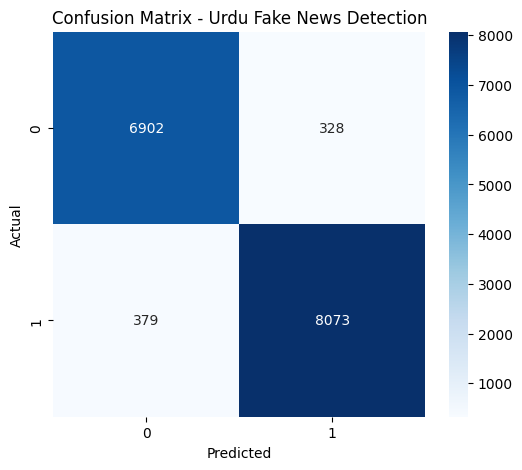

In [ ]:
# CONFUSION MATRIX
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()